In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from scipy import stats
import scipy
sbn.set_style('darkgrid')

In [2]:
data = pd.read_csv('credit_card_default_analysis.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Создадим два DF: 
1. Люди, вернувшие кредит
2. Люде, креди не вернувшие



In [3]:
credit_returned = data.query('default == 0')
credit_not_returned = data.query('default ==1')

## 1) Влияние Limit Bal 

Посмотрим на распределения 

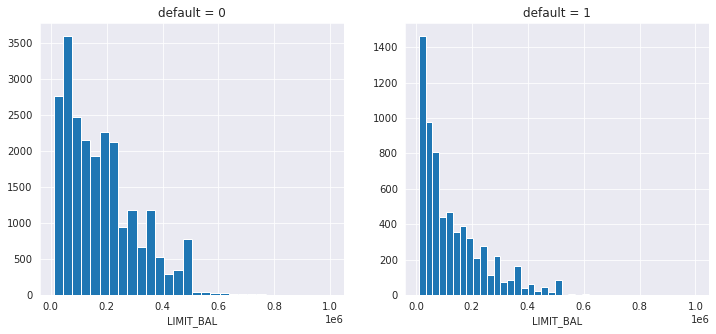

In [4]:
fig, axis = plt.subplots(1 , 2, figsize = (12,5), sharex = True)

axis[0].set_title('default = 0')
axis[0].set_xlabel('LIMIT_BAL')
credit_returned.LIMIT_BAL.hist(bins = 30, ax = axis[0])

axis[1].set_title('default = 1')
axis[1].set_xlabel('LIMIT_BAL')
credit_not_returned.LIMIT_BAL.hist(bins = 30, ax = axis[1]);

Видим, что распределения похожи, однако есть некоторые различия.  
Например, основаая масса заемщиков вернувших кредит имеет Limit bal меньше 200 000, тогда как люди не вернувшие кредит в основном имеют Limit bal меньше 100 000

#### 1.1 проверим гипотезу о равенстве медианных значений кредитного лимита

Посмтрим на медианы двух расперделений

In [5]:
print(' median default-0 = ', credit_returned.LIMIT_BAL.median(), '\n'
      ,'median default-1 = ', credit_not_returned.LIMIT_BAL.median())

 median default-0 =  150000.0 
 median default-1 =  90000.0


Посмотрим на интервальные оценки медиан двух распределений с помощью бутстрепа.  
Зададим функции для получения бутстреп-выборок и для получения доверительного интервала

In [6]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [7]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [8]:
LIMIT_BAL_bootstrap_samples_returned = get_bootstrap_samples(credit_returned.LIMIT_BAL.values, 1000)
LIMIT_BAL_bootstrap_samples_not_returned = get_bootstrap_samples(credit_not_returned.LIMIT_BAL.values, 1000)

In [9]:
LIMIT_BAL_medians_returned = [np.median(x) for x in LIMIT_BAL_bootstrap_samples_returned]
LIMIT_BAL_medians_not_returned = [np.median(x) for x in LIMIT_BAL_bootstrap_samples_not_returned]

посмотрим на полученные из выборок медианы

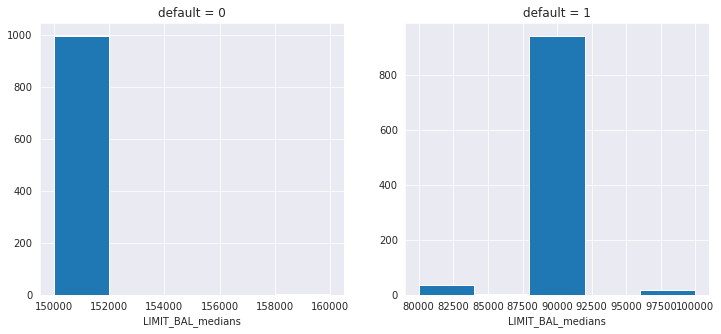

In [10]:
fig, axis = plt.subplots(1 , 2, figsize = (12,5))


axis[0].set_title('default = 0')
axis[0].set_xlabel('LIMIT_BAL_medians')
axis[0].hist(LIMIT_BAL_medians_returned, bins = 5);

axis[1].set_title('default = 1')
axis[1].set_xlabel('LIMIT_BAL_medians')
axis[1].hist(LIMIT_BAL_medians_not_returned, bins = 5);

Почти все выборочные медианы для default-0 получились одинаковыми

Посмотрим на 95% доверительные интервалы для полученных медиан в двух группах

In [11]:
print('95% доверительный интервал для медианы LIMIT BAL клиентов вернуших кредит',
      stat_intervals(LIMIT_BAL_medians_returned, 0.05))
      
print('95% доверительный интервал для медианы LIMIT BAL клиентов не вернуших кредит',
      stat_intervals(LIMIT_BAL_medians_not_returned, 0.05))

95% доверительный интервал для медианы LIMIT BAL клиентов вернуших кредит [150000. 150000.]
95% доверительный интервал для медианы LIMIT BAL клиентов не вернуших кредит [80000. 90000.]


Видим, что доверительные интервалы не пересекаются  

Посмотрим на доверительный интервал разности медиан

In [12]:
LIMIT_BAL_delta_median = [x[0] - x[1] for x in zip(LIMIT_BAL_medians_returned, LIMIT_BAL_medians_not_returned)]

In [13]:
print('95% доверительный интервал для разности медиан LIMIT BAL клиентов  вернувших и не вернуших кредит',
      stat_intervals(LIMIT_BAL_delta_median, 0.05))

95% доверительный интервал для разности медиан LIMIT BAL клиентов  вернувших и не вернуших кредит [60000. 70000.]


##### Доверительный интервал разности не пересекает 0, значит можно сделать вывод, что медианные значения кредитного лимита __не__ равны.

#### 1.2 Проверим гипотизу о равенстве распределений с помощью перестановочного критерия.

Напишем функции для проверки гипотез перестановочным критерием

In [14]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [15]:
def get_random_combinations(n1, n2, max_combinations):
    index = np.arange(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [16]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [17]:
def permutation_test(sample1, sample2, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

Будем проверять гипотезу H0 о равенстве распределений Limit bal клиентов вернувших кредит и не вернувших против двухсторонней альтернативы H1 о сдвиге между распределениями.


Посмотрим на нулевое распределение

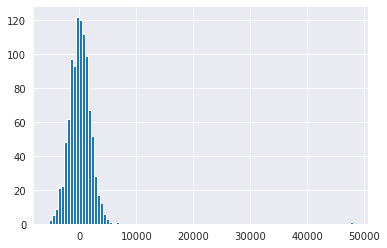

In [18]:
plt.hist(permutation_zero_dist_ind(credit_returned.LIMIT_BAL.values,
                                   credit_not_returned.LIMIT_BAL.values, 1000)
         ,bins = 100);

Видим странное значение статистики около 50 000. Распределение не симметричное.

Получим достигаемый уровень значимости 

In [19]:
print('достигаемый уровень значимости равен  = ',
      permutation_test(credit_returned.LIMIT_BAL.values, credit_not_returned.LIMIT_BAL.values,
                 1000 , alternative = 'two-sided'))

достигаемый уровень значимости равен  =  0.001


#### Таким образом, гепотеза о равенстве двух распределений отвергается на уровне значимости 0.05

Размер эффекта найдем как разность медиан 

In [20]:
effect_size = credit_returned.LIMIT_BAL.median() - credit_not_returned.LIMIT_BAL.median()

In [21]:
print('размер эффекта состовляет', effect_size)

размер эффекта состовляет 60000.0


Таким образом, клиенты не возвращающие кредит в седнем имеют кредитный лемит на 60 000 меньше. Это весомая сумма и на основание кредитного лимита можно делать базовые предположения о возврате или не возврате кредита.

# 2)  Проверьим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается

Посмотрим на распределение полов в двух группах.

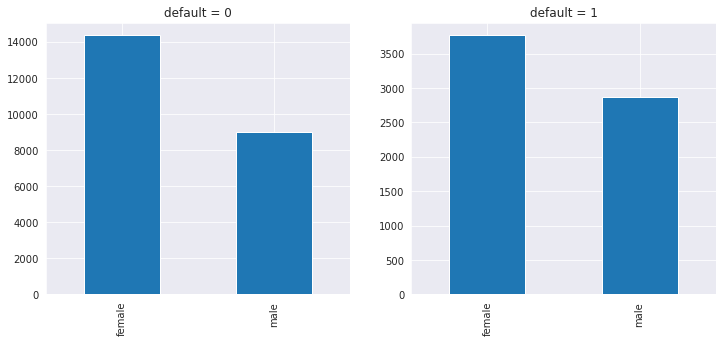

In [22]:
fig, axis = plt.subplots(1 , 2, figsize = (12,5))

axis[0].set_title('default = 0')
credit_returned.SEX. \
                map({1:'male',2:'female'}). \
                value_counts(). \
                plot(kind = 'bar', ax = axis[0])

axis[1].set_title('default = 1')
credit_not_returned.SEX. \
                map({1:'male',2:'female'}). \
                value_counts(). \
                plot(kind = 'bar', ax = axis[1])

Видим, визульно доли мужчин и женщин в двух группах приблизительно равны.  
Проверим это с помощью Z-критерия для доли для двух независимых выборок.  
Проверим нулевую гипотезу H0 о равенстве долей мужчин и женщин в двух группах против двухсторонней альтернативы.  

Также посмотрим на доверительный интервал для разности долей.

Функции для вычисления p-value и доверительного интервала.

In [23]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [24]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [25]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

Для удобства напишем функцию, которая переводит метки классов из  
1 - мужчина, 2- женщина __=>__
0 - мужчина, 1- женщина



In [26]:
credit_returned['SEX'] = credit_returned.SEX.map({1 : 0, 2 : 1})
credit_not_returned['SEX'] = credit_not_returned.SEX.map({1 : 0, 2 : 1})

<ipython-input-26-a0cf57cdcb2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_returned['SEX'] = credit_returned.SEX.map({1 : 0, 2 : 1})
<ipython-input-26-a0cf57cdcb2d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_not_returned['SEX'] = credit_not_returned.SEX.map({1 : 0, 2 : 1})


Посмотрим на доверительный интервал для разности двух долей

In [27]:
print('95% доверительный интервал для разности долей ',
      proportions_diff_confint_ind(credit_returned.SEX.values, credit_not_returned.SEX.values, 0.05))

95% доверительный интервал для разности долей  (0.03363493274962867, 0.060548077974896725)


Видим, что инетрвал не содержит 0, а значит можно сделать вывод о том, что гендерный состав среди клиентов банка вернувших кредит и не вернувших кредит отличается.

Найдем z-статистику а затем p-value

In [28]:
z_stat_SEX = proportions_diff_z_stat_ind(credit_returned.SEX.values, credit_not_returned.SEX.values)
print('достигаемый уровень значимости равен  = ',proportions_diff_z_test(z_stat_SEX))

достигаемый уровень значимости равен  =  4.472866521609831e-12


#### Таким образом, нулевая гипотиза о равенстве долей отвергается в пользу двухсторонней альтернативы на уровне значимости 0.05

Найдем размер эффекта как разность долей женщин среди клиентов вернувших и не вернувших кредит

In [29]:
p_1 = credit_returned.SEX.sum()/credit_returned.shape[0]
p_2 = credit_not_returned.SEX.sum()/credit_not_returned.shape[0]
effect_size = p_1 - p_2
print('размер эффекта =', effect_size)

размер эффекта = 0.0470915053622627


Видим, что доля мужчин среди клиентов вернувших кредит приблизительно на 5% больше чем доли мужчин не вернувших кредит.
Сложно судить о практической значимости такого результата, однако можно утверждать, что статистически он значим.

# 3) Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг

Построим на гистограммы 

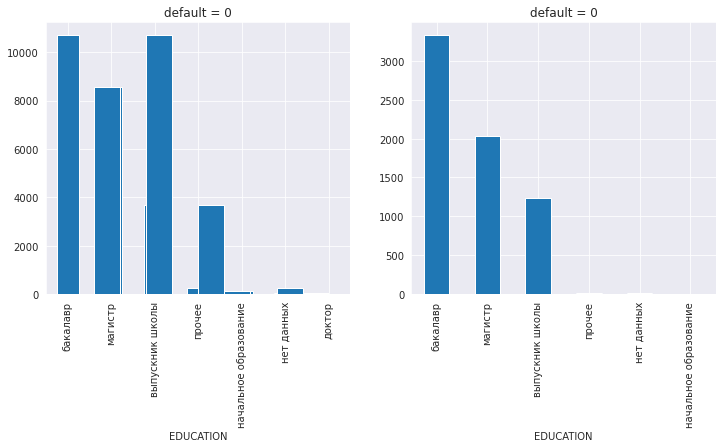

In [30]:
fig, axis = plt.subplots(1 , 2, figsize = (12,5))

axis[0].set_title('default = 0')
axis[0].set_xlabel('EDUCATION')

credit_returned.EDUCATION. \
                map({0 : 'доктор', 1 : 'магистр', 2 : 'бакалавр', 3 : 'выпускник школы',
                     4 : 'начальное образование', 5 : 'прочее', 6 : 'нет данных'}). \
                value_counts(). \
                plot(kind = 'bar', ax = axis[0])


credit_returned.EDUCATION.hist(ax = axis[0]);

axis[1].set_title('default = 0')
axis[1].set_xlabel('EDUCATION'),
credit_not_returned.EDUCATION. \
                map({0 : 'доктор', 1 : 'магистр', 2 : 'бакалавр', 3 : 'выпускник школы',
                     4 : 'начальное образование', 5 : 'прочее', 6 : 'нет данных'}). \
                value_counts(). \
                plot(kind = 'bar', ax = axis[1])

видим, что распределения в целом похожи, однако есть некоторые различия. Например, отсутствие среди не вернувших кредит людей с образованием 0 - доктор, а также меньшую долю людей с образованием 1 - магистр

Соберем таблицу сопряженности образование" на "возврат долга"

In [31]:
education_df = data.pivot_table(index = ['EDUCATION'], columns=['default'],
                                aggfunc= len, fill_value= 0, values = 'AGE')

education_df.index = ['доктор', 'магистр', 'бакалавр', 'выпускник школы',
                      'начальное образование', 'прочее', 'нет данных']

education_df

default,0,1
доктор,14,0
магистр,8549,2036
бакалавр,10700,3330
выпускник школы,3680,1237
начальное образование,116,7
прочее,262,18
нет данных,43,8


Проверим нулевую гипотезу H0 об отсутствие связи между образованием и возвратом долга против двухсторонней альтернативы.  
Проверку будем проводить с помощью критерия хи-квадрат для категориальных признаков.

In [32]:
stat, p_value, dof, expected_table  = stats.chi2_contingency(education_df.values)
print('достигаемый уровень значимости равен ', p_value)

достигаемый уровень значимости равен  1.2332626245415605e-32


#### Гипотеза о том, что образование не влияет на то, вернет ли человек долг, уверенно отвергается на уровне значимости 0.05

Посмотрим на таблицу сопряженности ожидаемых величин

In [33]:
exp_table_pd = pd.DataFrame(expected_table.round(), index = education_df.index.tolist())
exp_table_pd

,0,1
доктор,11.0,3.0
магистр,8244.0,2341.0
бакалавр,10927.0,3103.0
выпускник школы,3829.0,1088.0
начальное образование,96.0,27.0
прочее,218.0,62.0
нет данных,40.0,11.0


Составим таблицу разности реальных и ожидаемых значений

In [34]:
dif_education = education_df - exp_table_pd
dif_education

default,0,1
доктор,3.0,-3.0
магистр,305.0,-305.0
бакалавр,-227.0,227.0
выпускник школы,-149.0,149.0
начальное образование,20.0,-20.0
прочее,44.0,-44.0
нет данных,3.0,-3.0


Поделим каждое значение столбца 0 таблцы разности на соответствующее значение изначальной таблицы сопряженности. 

Таким образом мы найдем на сколько процентов наблюдаемые величины должны были быть больше или меньше, чтобы появилась возможность утверждать о независимости образования и возврата кредита. (нормированные разности)

Чем больше абсолютное значение такой доли, тем больше данный тип образования влияет на возврат долга 

Если значение положительное, то кол-во людей вернувших долг с таким уровнем образования больше ожидаемого, а значит люди с таким уровнем образования чаще возвращают долг. Если отрицательное, то чаще не возвращают.

Построим график.

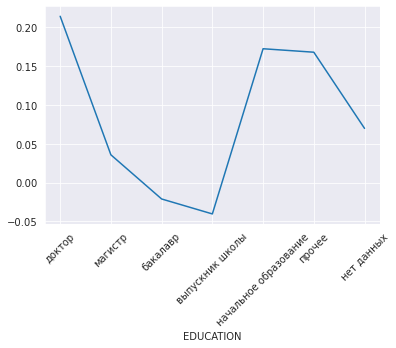

In [35]:
plt.plot(dif_education[0]/education_df[0] )
plt.xlabel('EDUCATION');
plt.xticks(rotation=45);

Видим, что больше всего нормированное отклонение от ожидания при уровне образования 0- доктор, однако таких людей всего 14 на всю выборку.  
Также, большое значения принимают отклонения при уровне образования 4 - начальное образование.  
Наименьшее значение принимается при уровне образования 3 - выпускник школы.

Таким образом, можно предположить, что люди с уровнем образованием  доктор или начальное образование отдают кредит чаще, а люди с уровнем образования выпускник школы возвращают кредит реже. 

# 4) Проверим, связаны ли семейное положение и возврат кредита.

Построим гистограммы

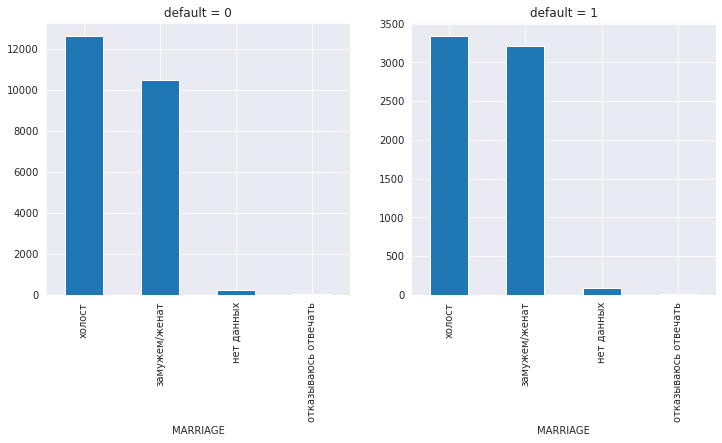

In [36]:
fig, axis = plt.subplots(1 , 2, figsize = (12,5), sharex = True)

axis[0].set_title('default = 0')
axis[0].set_xlabel('MARRIAGE')
credit_returned.MARRIAGE. \
                map({0 : 'отказываюсь отвечать', 1 : 'замужем/женат', 2 : 'холост', 3 : 'нет данных'}). \
                value_counts(). \
                plot(kind = 'bar', ax = axis[0]);

axis[1].set_title('default = 1')
axis[1].set_xlabel('MARRIAGE')
credit_not_returned.MARRIAGE. \
                    map({0 : 'отказываюсь отвечать', 1 : 'замужем/женат', 2 : 'холост', 3 : 'нет данных'}). \
                    value_counts(). \
                    plot(kind = 'bar', ax = axis[1]);

видим, что доля людей с семейным положением замужем/женат выше у группы не отдавших кредит.

Проверим, связаны ли как-то семейное положение и факт возврата кредита с помощью критерия V-Крамера 

In [37]:
def V_Cramer(table):
    chi2 = stats.chi2_contingency(table)[0]
    n =sum(sum(table))
    
    min_ = min(table.shape)
    
    return np.sqrt(chi2/(n * (min_ - 1)))

Составим сводную таблицу

In [38]:
table_marriage = data.pivot_table(index = ['MARRIAGE'], columns = ['default'],
                                  fill_value = 0, aggfunc = len, values = 'AGE')

table_marriage.index = ['отказываюсь отвечать', 'замужем/женат', 'холост', 'нет данных']
table_marriage

default,0,1
отказываюсь отвечать,49,5
замужем/женат,10453,3206
холост,12623,3341
нет данных,239,84


Посчитаем коэффициент V-Крамера

In [39]:
print('Коэффициент V Крамера равен', V_Cramer(table_marriage.values))

Коэффициент V Крамера равен 0.034478203662766466


Проверим, можно ли считать данные при таком коэф-те Крамера независимыми 

Будем проверять нулевую гипотезу H0 - семейное положение и возврат долга независимы против двухсторонней альтернативы с помощью критерия хи-квадрат для категориальных признаков.

In [40]:
chi, p_value, dof, table = stats.chi2_contingency(table_marriage)

In [41]:
print('достигаемый уровень значимости равен ', p_value)

достигаемый уровень значимости равен  8.825862457577375e-08


#### Таким образом, нулевая гепотеза о независимости семейного положения и возврата кредита отвергается на уровне значимости 0.05


# 5) Влияние возраста

Построим гистограммы

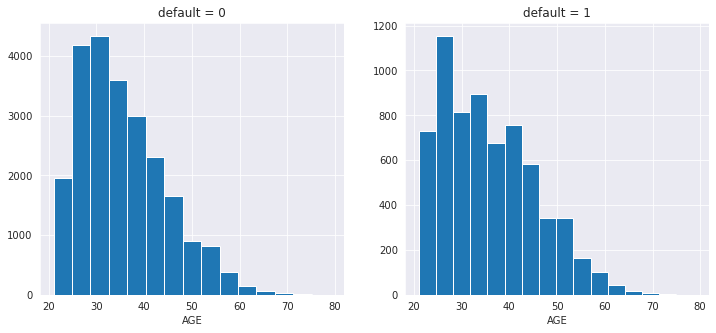

In [42]:
fig, axis = plt.subplots(1 , 2, figsize = (12,5), sharex = True)

axis[0].set_title('default = 0')
axis[0].set_xlabel('AGE')
credit_returned.AGE.hist(ax = axis[0], bins = 15);

axis[1].set_title('default = 1')
axis[1].set_xlabel('AGE')
credit_not_returned.AGE.hist(ax = axis[1], bins = 15);

Видим, что между распределениями есть небольшие различия

#### 5.1 проверим гипотезу о равенстве медианных значений кредитного лимита

Посмотрим на интервальные оценки медиан двух распределений с помощью бутстрепа.  

In [43]:
AGE_bootstrap_samples_returned = get_bootstrap_samples(credit_returned.AGE.values, 1000)
AGE_bootstrap_samples_not_returned = get_bootstrap_samples(credit_not_returned.AGE.values, 1000)

AGE_medians_returned = [np.median(x) for x in AGE_bootstrap_samples_returned]
AGE_medians_not_returned = [np.median(x) for x in AGE_bootstrap_samples_not_returned]

посмотрим на полученные из выборок медианы

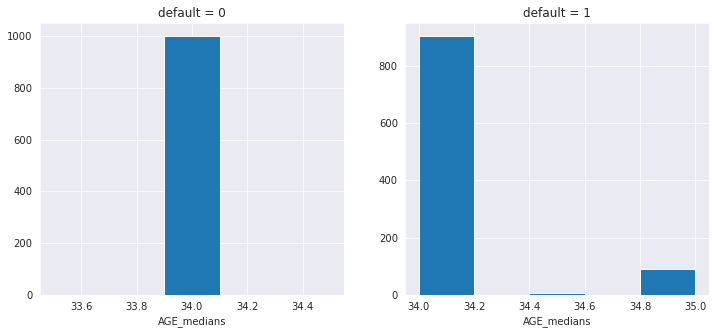

In [44]:
fig, axis = plt.subplots(1 , 2, figsize = (12,5))


axis[0].set_title('default = 0')
axis[0].set_xlabel('AGE_medians')
axis[0].hist(AGE_medians_returned, bins = 5);

axis[1].set_title('default = 1')
axis[1].set_xlabel('AGE_medians')
axis[1].hist(AGE_medians_not_returned, bins = 5);

Почти все выборочные медианы для default-0 получились одинаковыми

Посмотрим на 95% доверительные интервалы для полученных медиан в двух группах

In [45]:
print('95% доверительный интервал для медианы AGE клиентов вернуших кредит',
      stat_intervals(AGE_medians_returned, 0.05))
      
print('95% доверительный интервал для медианы AGE клиентов не вернуших кредит',
      stat_intervals(AGE_medians_not_returned, 0.05))

95% доверительный интервал для медианы AGE клиентов вернуших кредит [34. 34.]
95% доверительный интервал для медианы AGE клиентов не вернуших кредит [34. 35.]


Видим, что доверительные интервалы пересекаются, значит мы не можем отклонить гипотезу о равенстве медианных значений возрастов клиентов вернувших и не вернувших кредит.

Посмотрим на доверительный интервал для разности медиан

In [46]:
AGE_delta_median = [x[0] - x[1] for x in zip(AGE_medians_returned, AGE_medians_not_returned)]

print('95% доверительный интервал для разности медиан AGE клиентов  вернувших и не вернуших кредит',
      stat_intervals(AGE_delta_median, 0.05))

95% доверительный интервал для разности медиан AGE клиентов  вернувших и не вернуших кредит [-1.  0.]


#### 95% доверительный интервал пересекает 0, а значит мы также не можем отклонить гипотезу о равенстве медианных значений.

#### 5.2 Проверим гипотизу о равенстве распределений с помощью перестановочного критерия.

Будем проверять гипотезу H0 о равенстве распределений AGE клиентов вернувших кредит и не вернувших против двухсторонней альтернативы H1 о сдвиге между распределениями.

Посмотрим на нулевое распределение

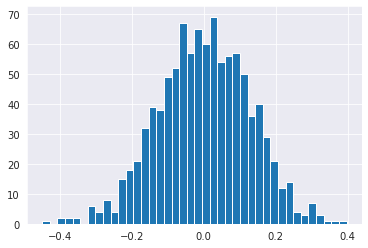

In [47]:
plt.hist(permutation_zero_dist_ind(credit_returned.AGE.values,
                                   credit_not_returned.AGE.values, 1000)
         ,bins = 40);

Получим достигаемый уровень значимости

In [48]:
print('достигаемый уровень значимости равен  = ',
      permutation_test(credit_returned.AGE.values, credit_not_returned.AGE.values,
                       1000,alternative = 'two-sided'))

достигаемый уровень значимости равен  =  0.016


#### Нулевая гипотеза отвергается на уровне значимости 0.05, т.е. между двумя распределениями есть сдвиг 

Посмотрим на размер эффекта.  
Найдем его как разность медианных значений двух групп

In [49]:
effect_size = credit_returned.AGE.median() - credit_not_returned.AGE.median()
print('размер эффекта = ', effect_size)

размер эффекта =  0.0


Таким образом, не зависимо от того, что перестановочный критерий показал наличие статистически значимого сдвига двух распределений, практической значимости это не представляет.